<a href="https://colab.research.google.com/github/lnsayer/udemy_ml_course/blob/main/02_pytorch_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [2]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [3]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                       "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

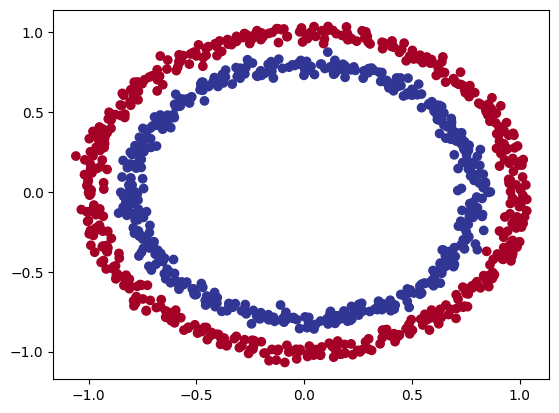

In [5]:
# Visualise with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### Let's find out how we could build a PyTorch neural network to classify dots into red(0) and blue(1)

You can familiarise yourself with the shape of the data you're working with to get over tensor mismatches etc.

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X[0]

array([0.75424625, 0.23148074])

In [8]:
# Turn our data into tensors
# Otherwise this causes issues with computations later on
import torch
X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

X_tensor[:5], y_tensor[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2,
                                                    random_state=42)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Let's create a model class that:
1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of `nn.Module`)
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of X and y
3. Defines a `forward` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target `device`.

In [11]:
# 1. Construct a model class that subclasses nn.Module

from torch import nn

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling X and y input
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  # 3. Define a forward method containing the forward pass computation
  def forward(self, x):
    # Return the output of layer_2, a single feature, the same shape as y
    return self.layer_2(self.layer_1(x))
# 4. Create an instance of the model and send it to target device

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

`nn.Sequential` performs a forward pass computation of the input data through the layers in the order they appear

In [12]:
# Replicate CircleModelv0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\n First 10 predictions {untrained_preds[:10]}")
print(f"\n First 10 test labels: \n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

 First 10 predictions tensor([[-0.3083],
        [-0.2456],
        [-0.3283],
        [-0.3032],
        [-0.0994],
        [-0.0629],
        [-0.0679],
        [-0.0246],
        [-0.3379],
        [-0.2389]], device='cuda:0', grad_fn=<SliceBackward0>)

 First 10 test labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [14]:
untrained_preds.squeeze_()
untrained_preds[:10], untrained_preds.shape

(tensor([-0.3083, -0.2456, -0.3283, -0.3032, -0.0994, -0.0629, -0.0679, -0.0246,
         -0.3379, -0.2389], device='cuda:0', grad_fn=<SliceBackward0>),
 torch.Size([200]))

In [15]:
import numpy as np
x = np.array([-2.2, -1.4, -.8, .2, .4, .8, 1.2, 2.2, 2.9, 4.6])
x.reshape(-1, 1)

array([[-2.2],
       [-1.4],
       [-0.8],
       [ 0.2],
       [ 0.4],
       [ 0.8],
       [ 1.2],
       [ 2.2],
       [ 2.9],
       [ 4.6]])

In [16]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.01)

In [17]:
# Create accuracy function
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
  return correct/len(y_pred)

In [18]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3083],
        [-0.2456],
        [-0.3283],
        [-0.3032],
        [-0.0994]], device='cuda:0', grad_fn=<SliceBackward0>)

The raw outputs of our model are referred to as logits . They are the unnormalised outputs and we need to normalise them to make proper predictions about the data.

In [19]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4235],
        [0.4389],
        [0.4187],
        [0.4248],
        [0.4752]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [20]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]
# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [21]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [22]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ## Training
  model_0.train()

  # 1. Forward pass (model outputs raw logits)
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCEloss you need torch.sigmoid()
  #                             y_train)

  loss = loss_fn(y_logits, y_train) # Using nn.BCEWithLogitsLoss works with raw logits
  acc= accuracy(y_true = y_train,
                y_pred = y_pred)
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Loss backwards
  loss.backward()

  #5. Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate the loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy(y_test,
                        test_pred)

  # Print out what's happening every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.3f} ")

Epoch: 0 | Test loss: 0.70145 | Test acc: 0.500 
Epoch: 10 | Test loss: 0.70068 | Test acc: 0.490 
Epoch: 20 | Test loss: 0.69998 | Test acc: 0.485 
Epoch: 30 | Test loss: 0.69937 | Test acc: 0.460 
Epoch: 40 | Test loss: 0.69882 | Test acc: 0.435 
Epoch: 50 | Test loss: 0.69833 | Test acc: 0.430 
Epoch: 60 | Test loss: 0.69789 | Test acc: 0.430 
Epoch: 70 | Test loss: 0.69750 | Test acc: 0.445 
Epoch: 80 | Test loss: 0.69715 | Test acc: 0.450 
Epoch: 90 | Test loss: 0.69683 | Test acc: 0.455 


Let's make a plot of our model's predictions, the data it's trying to predict and the decision boundary it's creating for whether something is class 0 or class 1.

In [23]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


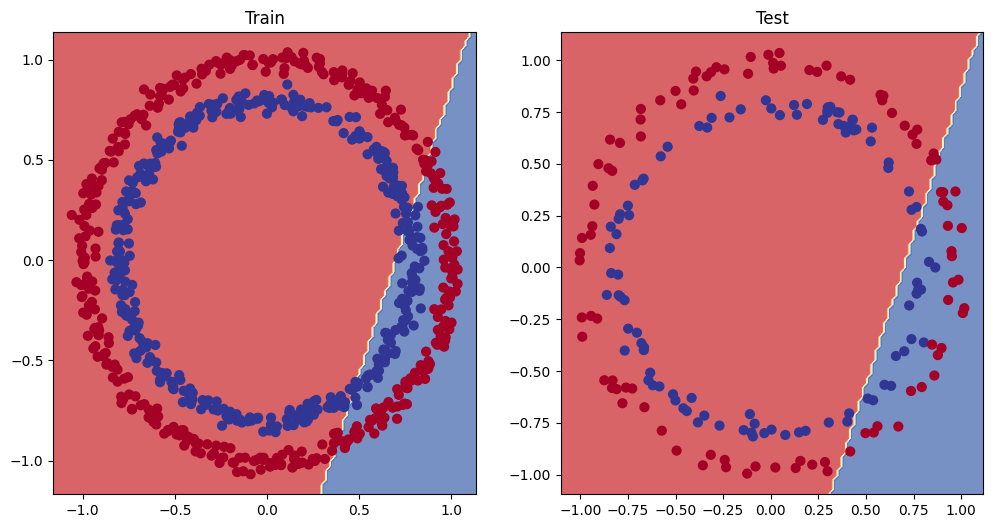

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [25]:
# Let's create a new model with more layers and run for longer
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [26]:
# loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [27]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 0.51% | Test loss: 0.69261, Test acc: 0.51%
Epoch: 100 | Loss: 0.69305, Accuracy: 0.50% | Test loss: 0.69379, Test acc: 0.48%
Epoch: 200 | Loss: 0.69299, Accuracy: 0.51% | Test loss: 0.69437, Test acc: 0.46%
Epoch: 300 | Loss: 0.69298, Accuracy: 0.52% | Test loss: 0.69458, Test acc: 0.45%
Epoch: 400 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69465, Test acc: 0.46%
Epoch: 500 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69467, Test acc: 0.46%
Epoch: 600 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69468, Test acc: 0.46%
Epoch: 700 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69468, Test acc: 0.46%
Epoch: 800 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69468, Test acc: 0.46%
Epoch: 900 | Loss: 0.69298, Accuracy: 0.51% | Test loss: 0.69468, Test acc: 0.46%


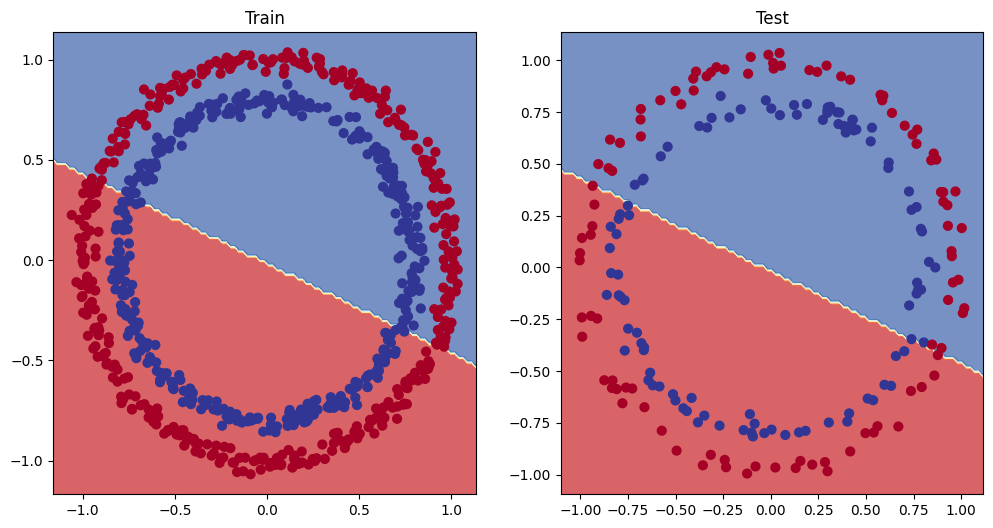

In [28]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Skipped the part about using our model for linear regression. Let's put a non-linear activation function in between the hidden layers in the forward pass.

In [29]:
# Build a model with non-linea activation function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features = 10)
    self.layer_2 = nn.Linear(in_features=10, out_features = 10)
    self.layer_3 = nn.Linear(in_features=10, out_features = 1)
    self.relu = nn.ReLU() # Could also put sigmoid in the function

  def forward(self, x):
    # Intersperse the ReLU activaiton function between layers
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [30]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr =0.1)


## Training a model with non-linearity

In [31]:
# Fit the model
torch.manual_seed(42)

# Define number of epochs
epochs = 4000
train_loss_arr = np.zeros(epochs)
test_loss_arr = np.zeros(epochs)

# Put all data onto target device
X_train, y_train, X_test, y_test = map(lambda x: x.to(device), [X_train, y_train, X_test, y_test])

for epoch in range(epochs):
  # Put the model in training mode
  model_3.train()
  # 1.  Forward pass
  y_logits = model_3(X_train).squeeze() # otherwise shape is torch.Size([800, 1])
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediciton probabilities -> prediciton labels

  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
  train_loss_arr[epoch] = loss
  acc = accuracy(y_train, y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward Pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_loss_arr[epoch] = test_loss
    test_acc = accuracy(y_test, test_pred)


  # Print out what's happening
  if epoch % 100 == 0 :
    print(f"Epoch: {epoch}, Accuracy: {acc:.2f}, Loss: {loss:.5f}, \
    Test_accuracy: {test_acc:.2f}, Test_loss: {test_loss:.5f}")

Epoch: 0, Accuracy: 0.50, Loss: 0.69295,     Test_accuracy: 0.50, Test_loss: 0.69319
Epoch: 100, Accuracy: 0.53, Loss: 0.69115,     Test_accuracy: 0.53, Test_loss: 0.69102
Epoch: 200, Accuracy: 0.53, Loss: 0.68977,     Test_accuracy: 0.55, Test_loss: 0.68940
Epoch: 300, Accuracy: 0.53, Loss: 0.68795,     Test_accuracy: 0.56, Test_loss: 0.68723
Epoch: 400, Accuracy: 0.53, Loss: 0.68517,     Test_accuracy: 0.56, Test_loss: 0.68411
Epoch: 500, Accuracy: 0.53, Loss: 0.68102,     Test_accuracy: 0.56, Test_loss: 0.67941
Epoch: 600, Accuracy: 0.55, Loss: 0.67515,     Test_accuracy: 0.56, Test_loss: 0.67285
Epoch: 700, Accuracy: 0.58, Loss: 0.66659,     Test_accuracy: 0.59, Test_loss: 0.66322
Epoch: 800, Accuracy: 0.64, Loss: 0.65160,     Test_accuracy: 0.68, Test_loss: 0.64757
Epoch: 900, Accuracy: 0.74, Loss: 0.62362,     Test_accuracy: 0.79, Test_loss: 0.62145
Epoch: 1000, Accuracy: 0.88, Loss: 0.56818,     Test_accuracy: 0.86, Test_loss: 0.57378
Epoch: 1100, Accuracy: 0.94, Loss: 0.48153, 

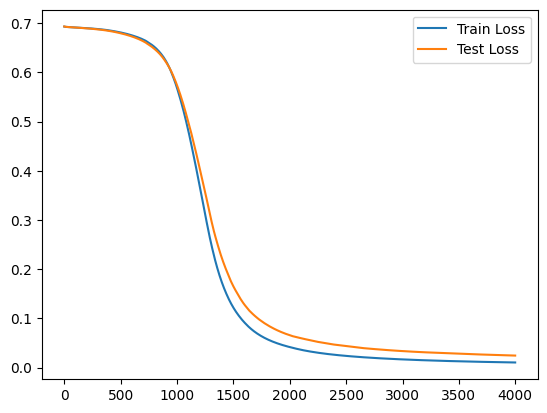

In [32]:
plt.plot(train_loss_arr, label="Train Loss")
plt.plot(test_loss_arr, label="Test Loss")
plt.legend()


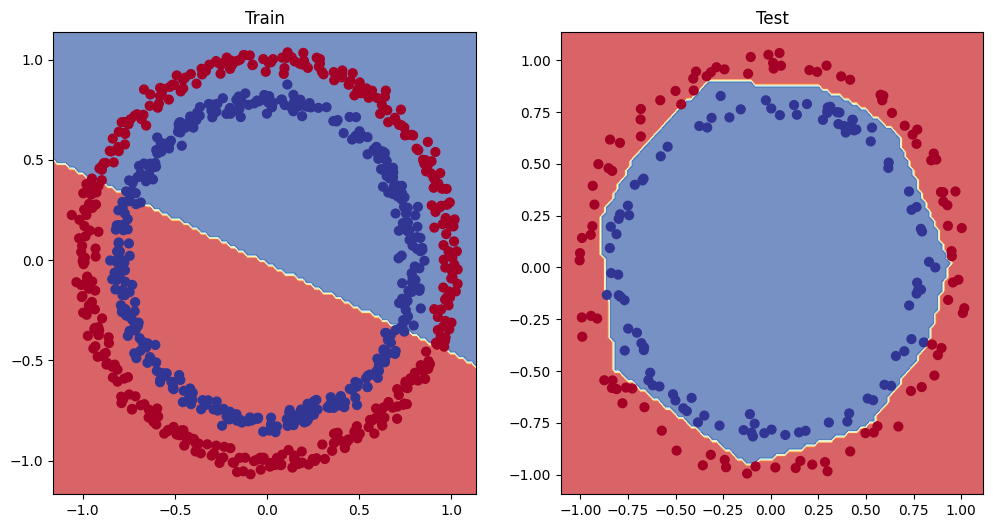

In [33]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 has no non-linearity
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 has non-linearity


## 8. Putting things together by building a multi-class PyTorch model


tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


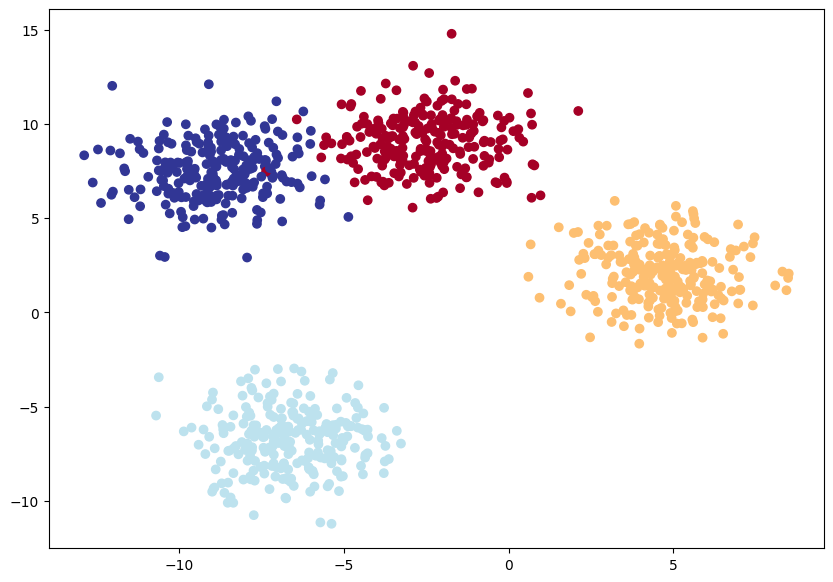

In [34]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class-data
X_blob, y_blob = make_blobs(n_samples = 1000,
                           n_features = NUM_FEATURES, # X features
                           centers=NUM_CLASSES, # y labels
                            cluster_std = 1.5, # give the clusters a little shake up
                            random_state = RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob,
            cmap=plt.cm.RdYlBu);

Let's create a subclass of nn.Module that takes in three hyperparameters:
- `input_features` The number of `X` features coming into the model
- ` output_features` the ideal numbers of output features we'd like (this will be equivalent to `NUM_CLASSES`
- `hidden_units` - the number of hidden neurons we'd like each hidden layer to use.


In [40]:
from torch import nn

input_features = NUM_FEATURES
output_features = NUM_CLASSES
hidden_units = 20


class Blobclassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_layer = nn.Linear(in_features= input_features,
                             out_features = hidden_units)
    self.hidden_layer_1 = nn.Linear(in_features = hidden_units,
                                    out_features = hidden_units)
    self.hidden_layer_2 = nn.Linear(in_features = hidden_units,
                                    out_features = hidden_units)
    self.output_layer = nn.Linear(in_features = hidden_units,\
                                   out_features = output_features)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.output_layer(self.relu(self.hidden_layer_2\
           (self.relu(self.hidden_layer_1(self.relu(self.\
           input_layer(x)))))))

model_blob = Blobclassifier().to(device)
print(model_blob)

Blobclassifier(
  (input_layer): Linear(in_features=2, out_features=20, bias=True)
  (hidden_layer_1): Linear(in_features=20, out_features=20, bias=True)
  (hidden_layer_2): Linear(in_features=20, out_features=20, bias=True)
  (output_layer): Linear(in_features=20, out_features=4, bias=True)
  (relu): ReLU()
)


In [41]:
epochs = 100

for epoch in range(epochs):

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
